In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk

# Reading News and Gold datas


In [2]:
gold_data = pd.read_excel ("Daily.xlsx")[['Date','Close']]
news_data = pd.read_excel ("News2.xlsx")[['Main Content','Published Date']]

news_data['Date'] = pd.to_datetime(news_data['Published Date']).dt.normalize().dt.strftime('%Y-%m-%d')

news_data = news_data[['Date','Main Content']]

gold_data['Date'] = pd.to_datetime(gold_data['Date']).dt.strftime('%Y-%m-%d')

news_data.head()

,Date,Main Content
0,2022-09-01,Helen Barth / UnsplashPack up the excavation k...
1,2022-10-12,Zlaťáky.cz / UnsplashInvestors are feeling anx...
2,2023-01-04,"UnsplashGold has been on a rampage recently, a..."
3,2023-02-02,Peter Olexa / UnsplashGold prices climb to a 9...
4,2023-02-10,Infrarate.com / UnsplashThe yellow metal is re...


## Calculate daily gold price change

In [3]:
gold_data['Change'] = gold_data['Close'].pct_change() * 100


gold_data.tail()

,Date,Close,Change
5320,2025-02-27,2877.12,-1.337055
5321,2025-02-28,2859.06,-0.627711
5322,2025-03-03,2892.99,1.186754
5323,2025-03-04,2917.70,0.854134
5324,2025-03-05,2917.18,-0.017822


## Tokenize each news

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [5]:
def preprocess_text(text):
    # Initialize NLTK's English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Filter out punctuation, special characters, and stopwords
    filtered_tokens = [
        word.lower() for word in tokens  # Convert to lowercase
        if word.isalnum() and word.lower() not in stop_words  # Remove non-alphanumeric and stopwords
    ]
    
    return filtered_tokens

In [6]:
news_data['Tokenized News'] = news_data['Main Content'].apply(preprocess_text)

news_data.head()

,Date,Main Content,Tokenized News
0,2022-09-01,Helen Barth / UnsplashPack up the excavation k...,"[helen, barth, unsplashpack, excavation, kit, ..."
1,2022-10-12,Zlaťáky.cz / UnsplashInvestors are feeling anx...,"[unsplashinvestors, feeling, anxious, week, fa..."
2,2023-01-04,"UnsplashGold has been on a rampage recently, a...","[unsplashgold, rampage, recently, experts, thi..."
3,2023-02-02,Peter Olexa / UnsplashGold prices climb to a 9...,"[peter, olexa, unsplashgold, prices, climb, hi..."
4,2023-02-10,Infrarate.com / UnsplashThe yellow metal is re...,"[unsplashthe, yellow, metal, reeling, low, gol..."


### Merge two dataframe

In [7]:
# Merge gold_data and news_data on the Date column
merged_data = pd.merge(gold_data, news_data, on='Date', how='outer')

# Sort by Date for better readability
merged_data = merged_data.dropna()

merged_data.tail()

,Date,Close,Change,Main Content,Tokenized News
5856,2025-03-05,2917.18,-0.017822,The broad market exchange-traded fund SPDR S&P...,"[broad, market, fund, spdr, p, 500, etf, trust..."
5857,2025-03-05,2917.18,-0.017822,"Key points:Spot gold down 0.1% at $2,913.79 an...","[key, points, spot, gold, ounceus, private, pa..."
5858,2025-03-05,2917.18,-0.017822,Key points:U.S. stocks nearly flat in midday t...,"[key, points, stocks, nearly, flat, midday, tr..."
5859,2025-03-05,2917.18,-0.017822,Front Month Comex Gold for March delivery gain...,"[front, month, comex, gold, march, delivery, g..."
5860,2025-03-05,2917.18,-0.017822,Key points:U.S. stocks end with gains of more ...,"[key, points, stocks, end, gains, 1, trump, de..."


## Calculate words vectors using Word2vec

In [8]:
model = Word2Vec(sentences=news_data['Tokenized News'], vector_size=100, window=5, min_count=1, workers=4)

In [9]:
def calculate_mean_vector(tokens):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0)  # Mean across all token vectors

In [10]:
merged_data['Vector'] = merged_data['Tokenized News'].apply(calculate_mean_vector)
merged_data['Vector']

4678    [0.21149582, -0.07602554, 0.10714019, -0.02590...
4707    [0.13530792, 0.044353016, 0.170888, -0.0872317...
4765    [0.13897817, -0.0014932527, 0.13338639, -0.005...
4786    [0.16197175, 0.033132803, 0.14317964, -0.08789...
4792    [0.15956056, -0.043311797, 0.02852633, -0.0129...
                              ...                        
5856    [-0.14960942, 0.4743455, 0.22474958, -0.264731...
5857    [0.11289627, 0.1077101, 0.087452956, -0.105039...
5858    [0.0033190395, 0.16756022, 0.11852773, -0.1438...
5859    [0.15739693, -0.011410219, 0.04716261, 0.06671...
5860    [0.006384455, 0.14918923, 0.15154062, -0.12413...
Name: Vector, Length: 881, dtype: object

In [11]:
merged_data['Mean'] = merged_data['Vector'].apply(lambda x: sum(x) / len(x))
merged_data.head()

,Date,Close,Change,Main Content,Tokenized News,Vector,Mean
4678,2022-09-01,1697.55,-0.785510,Helen Barth / UnsplashPack up the excavation k...,"[helen, barth, unsplashpack, excavation, kit, ...","[0.21149582, -0.07602554, 0.10714019, -0.02590...",-0.031287
4707,2022-10-12,1673.12,0.421343,Zlaťáky.cz / UnsplashInvestors are feeling anx...,"[unsplashinvestors, feeling, anxious, week, fa...","[0.13530792, 0.044353016, 0.170888, -0.0872317...",-0.034453
4765,2023-01-04,1854.68,0.826869,"UnsplashGold has been on a rampage recently, a...","[unsplashgold, rampage, recently, experts, thi...","[0.13897817, -0.0014932527, 0.13338639, -0.005...",-0.027074
4786,2023-02-02,1912.60,-1.920967,Peter Olexa / UnsplashGold prices climb to a 9...,"[peter, olexa, unsplashgold, prices, climb, hi...","[0.16197175, 0.033132803, 0.14317964, -0.08789...",-0.027661
4792,2023-02-10,1865.35,0.201978,Infrarate.com / UnsplashThe yellow metal is re...,"[unsplashthe, yellow, metal, reeling, low, gol...","[0.15956056, -0.043311797, 0.02852633, -0.0129...",-0.035084


# Predict Gold price changing

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [13]:
X = merged_data[['Mean']]  # Replace with your actual feature columns
y = merged_data['Change']  # Replace with your target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.01, max_depth=5)

# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


In [19]:
y_pred = xgb_model.predict(X_test)


In [20]:
def rsmpescore(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate symmetric absolute percentage errors
    symmetric_errors = np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    # Calculate SMPE (Symmetric Mean Percentage Error)
    smpe = np.mean(symmetric_errors)
    
    # Calculate RSMPE (Root SMPE)
    rsmpe = np.sqrt(smpe)
    
    return rsmpe

In [22]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


rsmpe = rsmpescore(y_test, y_pred)
print(f"RSMPE: {rsmpe*100:.2f}%")


Mean Squared Error: 0.7414015281955388
R² Score: 0.02545035083603675
RSMPE: 126.78%


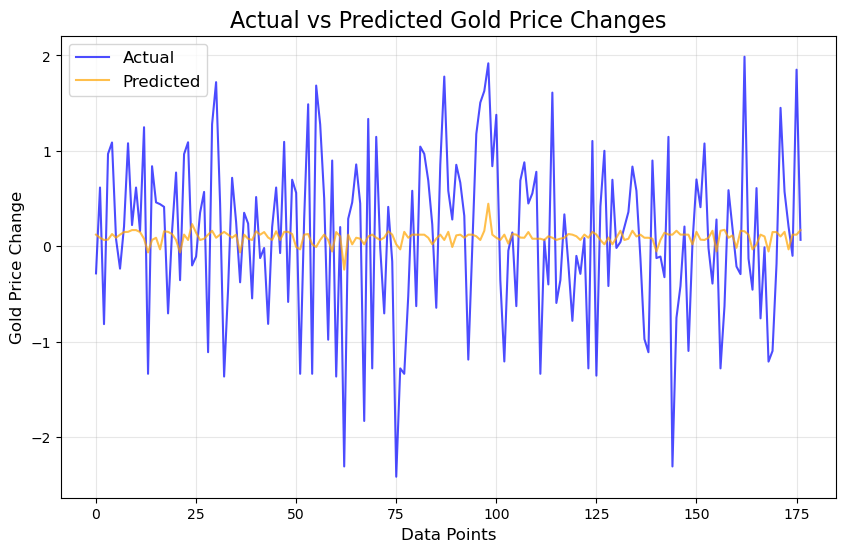

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: Replace y_test and y_pred with your actual data
actual = np.array(y_test)
predicted = np.array(y_pred)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual, label='Actual', color='blue', alpha=0.7)

# Plot predicted values
plt.plot(predicted, label='Predicted', color='orange', alpha=0.7)

# Add title and labels
plt.title('Actual vs Predicted Gold Price Changes', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Gold Price Change', fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Show the grid
plt.grid(alpha=0.3)

# Display the plot
plt.show()


## SVM


In [43]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [44]:
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can customize kernel, C, and epsilon based on your needs

# Train the model
svm_model.fit(X_train_scaled, y_train)


SVR()

In [50]:
y_pred = svm_model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


# Calculate R²
r2 = r2_score(y_test, y_pred)

# Print the result
print(f"R² Score: {r2}")


Mean Squared Error: 0.7501000163327819
R² Score: 0.014016454033801695


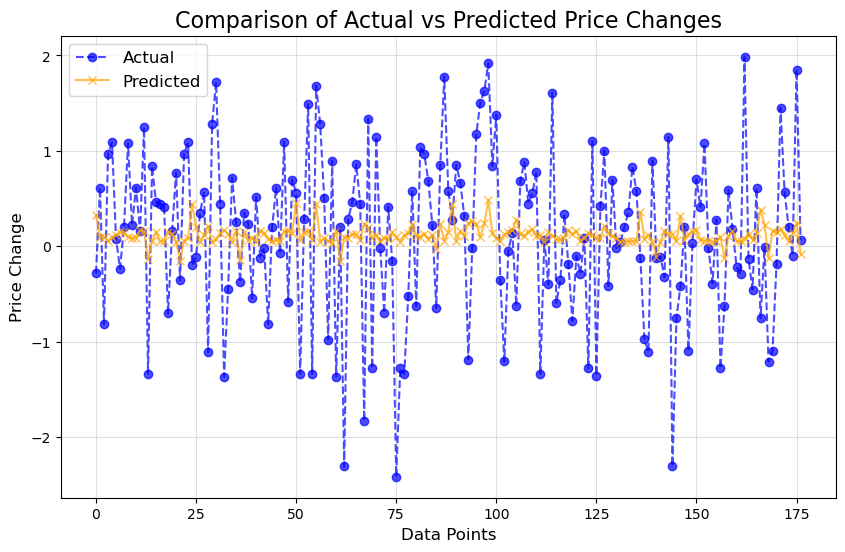

In [47]:

# Convert actual and predicted data into numpy arrays (if not already)
actual = np.array(y_test)  # Replace with your actual data
predicted = np.array(y_pred)  # Replace with your predicted data

# Create a figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual, label='Actual', color='blue', marker='o', alpha=0.7, linestyle='dashed')

# Plot predicted values
plt.plot(predicted, label='Predicted', color='orange', marker='x', alpha=0.7)

# Add title and labels
plt.title('Comparison of Actual vs Predicted Price Changes', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Price Change', fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Show grid for better readability
plt.grid(alpha=0.4)

# Display the plot
plt.show()


## K-means

In [68]:
print(merged_data['Mean'].shape)  # Check the shape of your news vectors
print(merged_data['Change'].values.reshape(-1, 1).shape)  # Check the shape of your price changes array


(881,)
(881, 1)


In [71]:
from sklearn.cluster import KMeans

price_changes_array = merged_data['Change'].values.reshape(-1, 1)
news_vectors = merged_data['Mean'].to_numpy()

price_changes_array = price_changes_array.reshape(-1, 1)

# Ensure news_vectors is already 2D
news_vectors = np.array(news_vectors)  
# Combine news vectors and price changes
X_combined = np.hstack((news_vectors, price_changes_array))  # Example

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_combined)

# Assign cluster labels to the original data
df['Cluster'] = clusters


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Visualize clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('News and Price Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
